<table>
<tr>
<td width=15%><img src="../../img/UGA.png"></img></td>
<td><center><h1>Project n°3</h1></center></td>
<td width=15%><a href="https://team.inria.fr/tripop/team-members/" style="font-size: 16px; font-weight: bold">Florian Vincent</a> </td>
</tr>
</table>

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Learning text classification

This project is heavily inspired from [Jigsaw's *Toxic Comments Classification* challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) on kaggle.
To avoid copy-pastings of foreign code, it will guide you towards specific tools to test and use.

## Overview of the project

Take a look at the *zip*ed csv data files by unzipping them (`for name in $(ls *.zip); do unzip $name; done;`).

Every comment in the train set is classified with a label in `{"toxic", "severe_toxic", "obscene", "threat", "insult", "identity hate"}`.
You will need to train multiple kind of models to identify those comments, and you will test them against the test dataset.

# Début du projet

Dans cette section, nous chargeons les fichiers de données CSV contenant les commentaires et leurs étiquettes associées. Ces données sont divisées en trois parties :
- **Entraînement** : Les commentaires avec leurs labels pour entraîner le modèle.
- **Test** : Les commentaires sans labels pour l'évaluation.
- **Labels de test** : Les étiquettes correspondantes aux données de test, utilisées pour évaluer la performance du modèle.


In [38]:
import pandas as pd

# Chargement des fichiers CSV
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
data_test_labels = pd.read_csv("test_labels.csv")

# Aperçu des cinq premières lignes de chaque dataset
print("**Aperçu des données d'entraînement :**")
print(data_train.head(), "\n")

print("**Aperçu des données de test :**")
print(data_test.head(), "\n")

print("**Aperçu des labels de test :**")
print(data_test_labels.head(), "\n")


**Aperçu des données d'entraînement :**
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0   

**Aperçu des données de test :**
                 id                                       comment_text
0  00001cee341fdb12

## Nettoyage des données

Les données textuelles brutes nécessitent un prétraitement avant d’être utilisées pour l’apprentissage automatique.  
Dans cette étape, nous effectuons plusieurs opérations pour nettoyer les commentaires :
1. **Suppression des caractères spéciaux** : Cela inclut les chiffres, les ponctuations et autres symboles non alphabétiques.
2. **Conversion en minuscule** : Pour uniformiser les textes.
3. **Tokenisation** : Séparer le texte en mots individuels.
4. **Suppression des stopwords** : Retirer les mots courants qui n’apportent pas d’information (ex. "the", "is").
5. **Lemmatisation** : Réduire chaque mot à sa racine grammaticale.

Nous créons une fonction `nettoyage` pour appliquer toutes ces étapes de manière systématique sur les données.


In [39]:
# Nettoyage des donnees 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer

In [40]:
# Suppression de la ponctuation et des sauts de lignes
data_train["comment_clean"] = data_train["comment_text"].apply(lambda x : re.sub("[^a-zA-Z]", ' ', x))
data_train[["comment_text", "comment_clean"]].head(6)

,comment_text,comment_clean
0,Explanation\nWhy the edits made under my usern...,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,D aww He matches this background colour I m s...
2,"Hey man, I'm really not trying to edit war. It...",Hey man I m really not trying to edit war It...
3,"""\nMore\nI can't make any real suggestions on ...",More I can t make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",You sir are my hero Any chance you remember...
5,"""\n\nCongratulations from me as well, use the ...",Congratulations from me as well use the to...


In [41]:
# Conversion en minuscule
data_train["comment_clean"] = data_train["comment_clean"].str.lower()
data_train[["comment_text", "comment_clean"]].head(6)

,comment_text,comment_clean
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,d aww he matches this background colour i m s...
2,"Hey man, I'm really not trying to edit war. It...",hey man i m really not trying to edit war it...
3,"""\nMore\nI can't make any real suggestions on ...",more i can t make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember...
5,"""\n\nCongratulations from me as well, use the ...",congratulations from me as well use the to...


In [42]:
# Tokenisation
from nltk.tokenize import TreebankWordTokenizer

# Tokeniseur alternatif
tokenizer = TreebankWordTokenizer()

# Application
data_train["comment_clean"] = data_train["comment_clean"].apply(tokenizer.tokenize)
print(data_train[["comment_text", "comment_clean"]].head(6))

                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   
5  "\n\nCongratulations from me as well, use the ...   

                                       comment_clean  
0  [explanation, why, the, edits, made, under, my...  
1  [d, aww, he, matches, this, background, colour...  
2  [hey, man, i, m, really, not, trying, to, edit...  
3  [more, i, can, t, make, any, real, suggestions...  
4  [you, sir, are, my, hero, any, chance, you, re...  
5  [congratulations, from, me, as, well, use, the...  


In [43]:
# Suppression des stopwords (mots de "liaisons" inutiles)
stop_words = set(stopwords.words("english"))

data_train["comment_clean"] = data_train["comment_clean"].apply(lambda x: [word for word in x if word not in stop_words])
data_train[["comment_text", "comment_clean"]].head(6)

,comment_text,comment_clean
0,Explanation\nWhy the edits made under my usern...,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,"[aww, matches, background, colour, seemingly, ..."
2,"Hey man, I'm really not trying to edit war. It...","[hey, man, really, trying, edit, war, guy, con..."
3,"""\nMore\nI can't make any real suggestions on ...","[make, real, suggestions, improvement, wondere..."
4,"You, sir, are my hero. Any chance you remember...","[sir, hero, chance, remember, page]"
5,"""\n\nCongratulations from me as well, use the ...","[congratulations, well, use, tools, well, talk]"


In [44]:
# Reconversion des listes en chaines de charactères
data_train["comment_clean"] = data_train["comment_clean"].apply(lambda x: " ".join(x))
data_train[["comment_text", "comment_clean"]].head(6)

,comment_text,comment_clean
0,Explanation\nWhy the edits made under my usern...,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,aww matches background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",make real suggestions improvement wondered sec...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",congratulations well use tools well talk


In [45]:
def nettoyage(df) :
    # Suppression de la ponctuation et des sauts de lignes
    df["comment_clean"] = df["comment_text"].apply(lambda x : re.sub("[^a-zA-Z]", ' ', x))

    # Conversion en minuscule
    df["comment_clean"] = df["comment_clean"].str.lower()

    # Tokenisation (séparation mot à mot)
    df["comment_clean"] = df["comment_clean"].apply(tokenizer.tokenize)

    # Suppression des stopwords (mots de "liaisons" inutiles)
    stop_words = set(stopwords.words("english"))
    df["comment_clean"] = df["comment_clean"].apply(lambda x: [word for word in x if word not in stop_words])

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    df["comment_clean"] = df["comment_clean"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    # Reconversion des listes en chaines de charactères
    df["comment_clean"] = df["comment_clean"].apply(lambda x: " ".join(x))

    return df

# Attention : la colonne de texte à traiter doit impérativement s'appeler "comment_text".

In [46]:
data_test = nettoyage(data_test)
data_test.head(6)

,id,comment_text,comment_clean
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,rfc title fine imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...",look back source information updated correct f...
4,00017695ad8997eb,I don't anonymously edit articles at all.,anonymously edit article
5,0001ea8717f6de06,Thank you for understanding. I think very high...,thank understanding think highly would revert ...


## Study the data

Representing textual data in an algebraic format (i.e. vectors & matrices) is not easy, but fortunately it has been quickly studied earlier in the lectures.

**Implement a word-vectorizer relying on simple counting for the textual data**

## Vectorisation avec CountVectorizer

Pour utiliser les commentaires comme entrée dans des modèles d'apprentissage automatique, nous devons les convertir en représentations numériques.  
Dans cette section, nous utilisons **CountVectorizer**, qui transforme les textes en une matrice creuse où chaque colonne correspond à un mot unique du vocabulaire, et chaque ligne correspond à un commentaire.  

**Sorties attendues :**
- Les dimensions de la matrice (nombre de commentaires × taille du vocabulaire).
- Un exemple de vocabulaire (quelques mots uniquement).
- Les valeurs numériques de la matrice pour les premiers commentaires.


In [47]:
from sklearn.feature_extraction.text import CountVectorizer

# Sélection de la colonne contenant les commentaires
corpus = data_train["comment_clean"]

# Initialisation du vectoriseur CountVectorizer
vectorizer = CountVectorizer()

# Transformation des commentaires en vecteurs de comptage
X = vectorizer.fit_transform(corpus)

# Sortie des dimensions
print(f"Dimensions de la matrice X (Commentaires x Vocabulaire) : {X.shape}\n")

# Affichage du vocabulaire (liste des mots)
print(f"**Exemple de mots du vocabulaire :** {vectorizer.get_feature_names_out()[:10]}...\n")

# Affichage de la matrice dense pour quelques commentaires
print("**Matrice de comptage (TF, Top 5 commentaires) :**\n")
print(X.toarray()[:5])



Dimensions de la matrice X (Commentaires x Vocabulaire) : (159571, 168640)

**Exemple de mots du vocabulaire :** ['aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany'
 'aaaaaaaaaah' 'aaaaaaaaaahhhhhhhhhhhhhh' 'aaaaaaaaadm' 'aaaaaaaaaq']...

**Matrice de comptage (TF, Top 5 commentaires) :**

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Vectorisation avec TF-IDF

La vectorisation **TF-IDF** (Term Frequency-Inverse Document Frequency) améliore la méthode CountVectorizer en pondérant chaque mot selon son importance dans le corpus.  
Cela réduit l'influence des mots très fréquents mais peu discriminants (comme "the", "is") et met en avant les mots spécifiques.

Dans cette section, nous utilisons `TfidfVectorizer` pour générer les vecteurs pondérés.


**Implement another vectorizing relying this time on the *tf-idf* metric. Use a pipeline if needed.**

In [48]:
## with the use of tf-idf the words thats re more accurate re less important so we wont have the redondant words when it comes to counting from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# The TfidfVectorizer: tokenazation  splits the text into smaller units called tokens (usually words)
# then vectorizer calculates the TF-IDF (Term Frequency-Inverse Document Frequency) value for each term in the corpus.
# which is the number of a token on the total number of all tokens  for term freq 
# Inverse Document Frequency or idf : is simply the log of the number of  documents or sentences thats containes the token (word)

# Pipeline avec  l'étape de TF-IDF
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000))  # Étape TF-IDF
])

# Charger le corpus
corpus1 = data_train["comment_clean"]
# Appliquer le pipeline
X_tfidf = pipeline.fit_transform(corpus1)

# Afficher les dimensions et les vecteurs train 
print("Shape de X_train :", X_tfidf.shape)  #nbre of documents x nbre of tokens (words)
#print("TF-IDF Vectors (sparse matrix):\n", X_tfidf)  # Matrice TF-IDF au format sparse qui stocke uniquement les valeurs non nulles , le doc , le mots et la ponderation tf-idf



Shape de X_train : (159571, 10000)



One may wish to take a deeper look in the database by using various techniques.

**Find a suitable dimension reduction technique to study the structure of the data. Display your findings with visual means (you can use `seaborn`).**

## Réduction de dimension avec PCA

Les données textuelles vectorisées ont souvent une très grande dimensionnalité (jusqu’à des milliers de mots).  
Pour analyser et visualiser ces données, nous utilisons la **réduction de dimension**.  
Dans cette section, nous appliquons la méthode PCA (Analyse en Composantes Principales) via `TruncatedSVD` pour réduire les vecteurs TF-IDF à seulement 2 dimensions, tout en conservant un maximum d’information.


In [49]:
##  one of he best methods to reduce the dimension to study the data is PCA principale composants analysis 
# on quantitatif variables .As words can take many values (string) its is the variables in question :)
from sklearn.decomposition import TruncatedSVD
#Pca  on sparse (non nulles ) 
svd = TruncatedSVD(n_components=2)
#fit and transform on the TF-IDF matrix but because it takes a lot of memory we can directly use the sparse matrix by 
# using truncatsvd .
res_pca= svd.fit_transform(X_tfidf)
print("Shape after dimensionality reduction:", res_pca.shape)
# create a data frame from svd result on tf_tfidf (PCA on  the sparse matrix )
df_pca = pd.DataFrame(res_pca, columns=['Dimension 1', 'Dimension 2'])

print(res_pca)


Shape after dimensionality reduction: (159571, 2)
[[ 1.51442565e-01  4.17284710e-02]
 [ 8.02079444e-02  1.26715938e-04]
 [ 1.76049697e-01 -4.09956213e-03]
 ...
 [ 3.73795380e-02 -3.34264885e-02]
 [ 1.40358784e-01 -7.94996861e-02]
 [ 8.02445750e-02 -6.49976700e-02]]


## Visualisation avec PCA et clustering

Les données réduites en 2 dimensions sont visualisées pour explorer leur structure.  
Nous ajoutons également une étape de **clustering KMeans** pour regrouper les commentaires similaires en fonction de leurs caractéristiques.  

Cela permet de mieux comprendre les relations entre les commentaires dans un espace réduit.


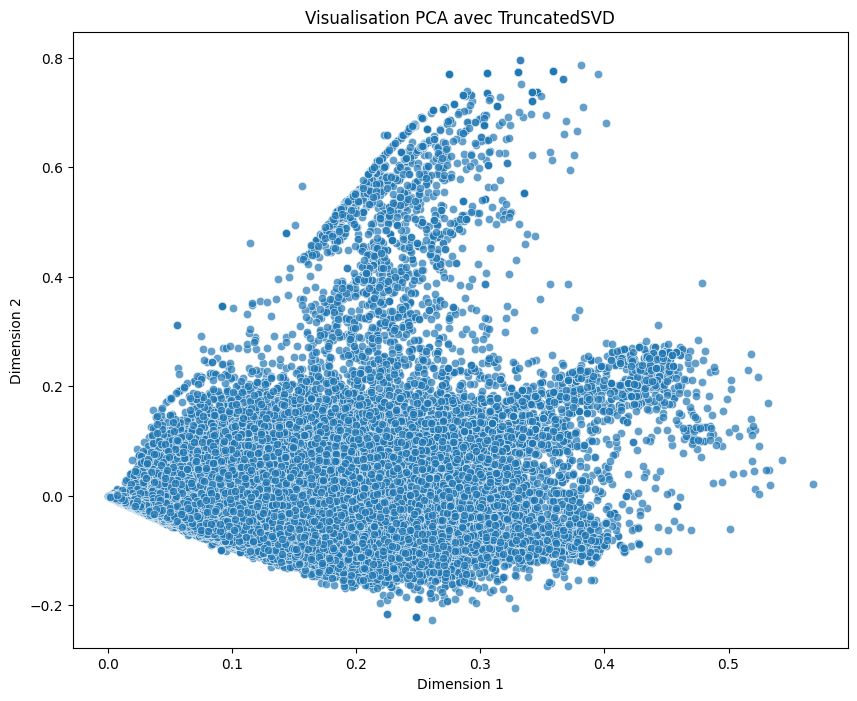

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
# DISPLAY
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimension 1',
    y='Dimension 2',  
    data=df_pca,  
    alpha=0.7  
)

plt.title('Visualisation PCA avec TruncatedSVD')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [51]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
n_clusters = 5  # Adjust based on the data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(res_pca)

print("Cluster centers:", kmeans.cluster_centers_)


Cluster centers: [[ 0.04494778 -0.01510417]
 [ 0.23745617  0.1243389 ]
 [ 0.11347849 -0.03897455]
 [ 0.24426958  0.55874026]
 [ 0.21869463 -0.04874172]]


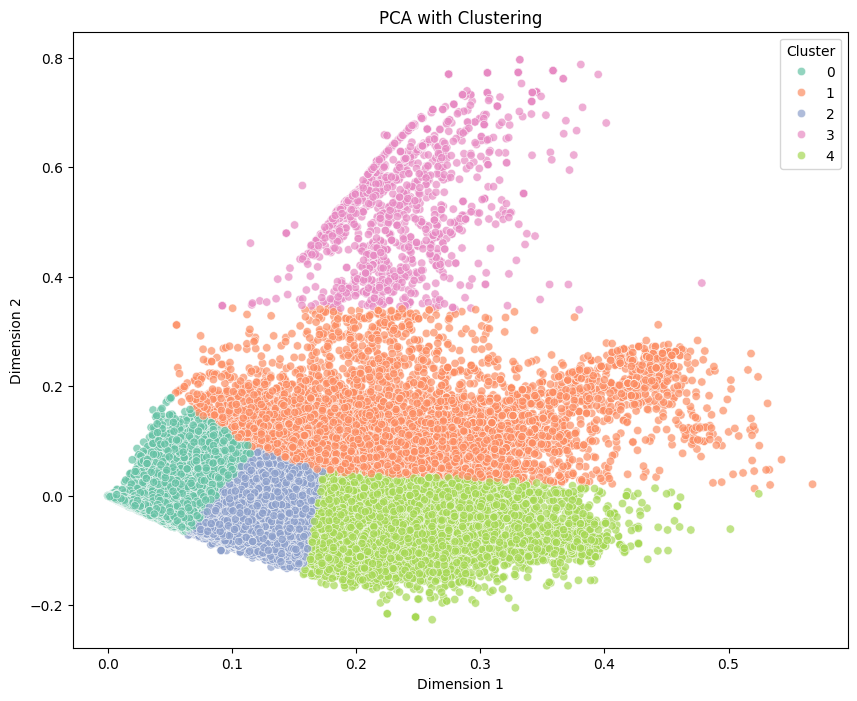

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot with clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimension 1',
    y='Dimension 2',
    hue='Cluster',
    palette='Set2',  # Color palette for clusters
    data=df_pca,
    alpha=0.7
)

plt.title('PCA with Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Cluster')
plt.show()


In [53]:
# Nombre de catégories associées à chaque commentaire
data_train['label_count'] = data_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)

# Afficher un aperçu
print(data_train[['label_count']].value_counts())


label_count
0              143346
1                6360
3                4209
2                3480
4                1760
5                 385
6                  31
Name: count, dtype: int64


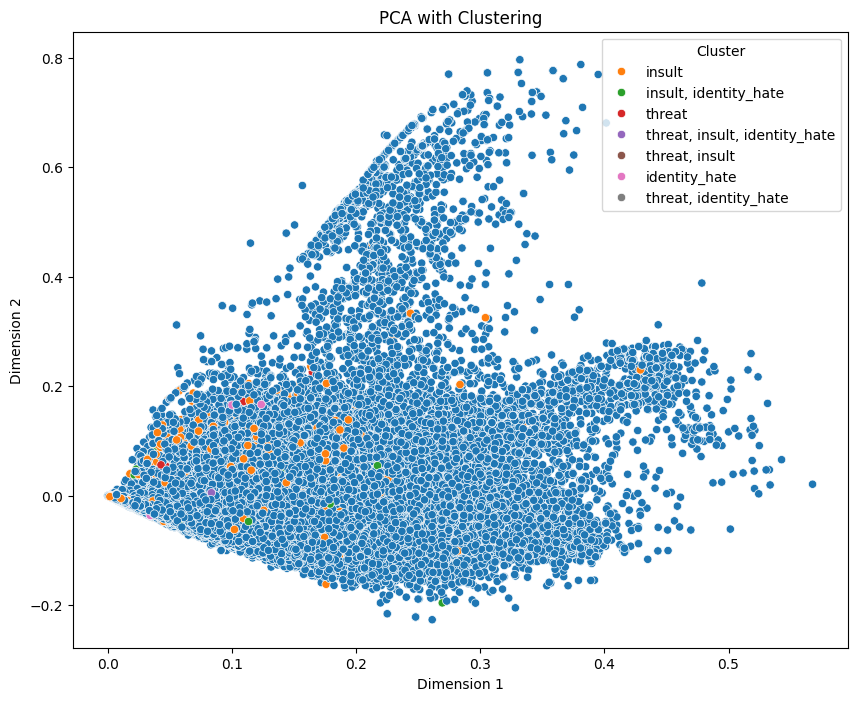

In [54]:
# using labels 
plt.figure(figsize=(10, 8))
#'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
data_train['combined_labels'] = data_train[['threat', 'insult', 'identity_hate']].apply(
    lambda x: ', '.join(x.index[x == 1]), axis=1
)
df_pca['Label'] = data_train['combined_labels']
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=df_pca, palette='tab10')
plt.title('PCA with Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Cluster')
plt.show()

#  The graph shows the distribution of comments in a reduced 2D space (PCA) , where points represent comments(individu ), 
# and their position reflects their similarity in terms of word usage and TF-IDF features .



## Make classification

We will study during this project a small amount of models.

### Logistic regression

The logistic regression is the most simple and naïve model one can use for classification specifically, but it can provide good insights on the baseline one may wish to achieve with more complex models.

**Implement a logistic classifier. Justify every parameter that you choose and how you chose it.**

## Préparation des données de test

Les étiquettes des données de test contiennent des valeurs `-1`, qui indiquent des commentaires sans étiquettes valides.  
Nous filtrons les données de test pour conserver uniquement les commentaires avec des étiquettes valides (>= 0). Cela garantit que nos modèles sont évalués sur des données correctement étiquetées.


In [55]:
## with the use of tf-idf the words thats re more accurate re less important so we wont have the redondant words when it comes to counting from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# The TfidfVectorizer: tokenazation  splits the text into smaller units called tokens (usually words)
# then vectorizer calculates the TF-IDF (Term Frequency-Inverse Document Frequency) value for each term in the corpus.
# which is the number of a token on the total number of all tokens  for term freq 
# Inverse Document Frequency or idf : is simply the log of the number of  documents or sentences thats containes the token (word)

# Pipeline avec  l'étape de TF-IDF
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000))  # Étape TF-IDF
])

# Charger le corpus
corpus1 = data_train["comment_clean"]
# Appliquer le pipeline
X_tfidf = pipeline.fit_transform(corpus1)

# Afficher les dimensions et les vecteurs train 
print("Shape de X_train :", X_tfidf.shape)  #nbre of documents x nbre of tokens (words)
#print("TF-IDF Vectors (sparse matrix):\n", X_tfidf)  # Matrice TF-IDF au format sparse qui stocke uniquement les valeurs non nulles , le doc , le mots et la ponderation tf-idf



Shape de X_train : (159571, 10000)


In [56]:
data_test=data_test.merge(data_test_labels, on="id")
# Convertir les colonnes à partir de la 3ème colonne en numériques
#data_test.iloc[:, 3:] = data_test.iloc[:, 3:].apply(pd.to_numeric, errors='coerce')
# Filtrage des lignes où la somme des colonnes à partir de la 3ème est >= 0
data_test = data_test[data_test.iloc[:, 3:].sum(axis=1) >= 0]

In [57]:

data_test.head()

,id,comment_text,comment_clean,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,thank understanding think highly would revert ...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,dear god site horrible,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",somebody invariably try add religion really me...,0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",say right type type institution needed case th...,0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",adding new product list make sure relevant add...,0,0,0,0,0,0


In [58]:
data_test.head()

,id,comment_text,comment_clean,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,thank understanding think highly would revert ...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,dear god site horrible,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",somebody invariably try add religion really me...,0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",say right type type institution needed case th...,0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",adding new product list make sure relevant add...,0,0,0,0,0,0


## Logistic Regression : Classification des commentaires toxiques

La régression logistique est un modèle simple mais efficace pour une classification binaire.  
Nous entraînons un modèle pour prédire si un commentaire est "toxique" (`1`) ou "non-toxique" (`0`).  

**Paramètres choisis :**
- `solver='liblinear'` : Adapté aux  problèmes de classification binaire.
- `C=1.0` : Paramètre de régularisation (valeur par défaut).
- `class_weight='balanced'` : Pour compenser le déséquilibre des classes.

Nous évaluerons le modèle avec un rapport de classification et une matrice de confusion.


In [59]:
## logistic classifier 
# les commentaires toxiques.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
model = LogisticRegression(solver='liblinear', C=0.1,class_weight='balanced', random_state=0)

# X : Les commentaires transformés en vecteurs numériques avec TF-IDF
# X_tfidf est la matrice résultante de la transformation des commentaires nettoyés en une représentation numérique 
# (chaque ligne est un commentaire, et chaque colonne représente un mot, avec les valeurs TF-IDF associées).
X_train = X_tfidf
# Y : Le label (binaire pour toxicité)
# Ici, nous utilisons la colonne 'toxic' de 'data_train' comme étiquette cible.
# Cette colonne contient des valeurs 0 ou 1, représentant si le commentaire est toxique ou non.
y_train = data_train["toxic"]
# Entraînement du modèle avec les données X_train (les vecteurs des commentaires)
# et y_train (les étiquettes correspondantes de toxicité).
model.fit(X_train, y_train)
# Après l'entraînement du modèle, on peut maintenant faire des prédictions sur de nouvelles données.
# Affiche les classes que le modèle peut prédire.
# Cela montre les étiquettes de classification possibles (dans ce cas, 'toxic' ou 'non-toxic' pour un modèle binaire).
# présenter par la liste 0,1
print(model.classes_)
# Affiche l'ordonnée à l'origine du modèle (le biais).
print(model.intercept_)
# Affiche les coefficients du modèle pour chaque caractéristique (mot dans ce cas).
print(model.coef_)

[0 1]
[-0.52821756]
[[ 0.03487401 -0.1041183  -0.04150499 ...  0.10993533 -0.10543881
   0.21924713]]


In [60]:
# # avec pca 
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix

# # Étape 1 : Réduction de la dimensionnalité avec PCA
# pca = PCA(n_components=300, random_state=0)
# X_train_reduced = pca.fit_transform(X_train)

# # Étape 2 : Régression logistique avec les données réduites
# model2 = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', random_state=0)

# # Entraînement du modèle
# model2.fit(X_train_reduced, y_train)

# # Étape 3 : Résultats du modèle
# print("Classes prédites :", model2.classes_)
# print("Ordonnée à l'origine (biais) :", model2.intercept_)
# print("Coefficients du modèle :", model2.coef_)




Classes prédites : [0 1]
Ordonnée à l'origine (biais) : [-1.04332393]
Coefficients du modèle : [[-8.22244100e+00  7.86156556e+00  2.25773110e+00 -3.37994663e+00
   1.65194901e+00  1.31681431e+00 -1.07421851e+01  9.28702426e+00
   1.33754257e+01  6.16035568e+00  8.27522314e+00  1.11366253e-02
  -2.17829405e+00 -1.90585359e+00  1.57528137e+00 -4.19257035e+00
  -2.03648681e+00 -1.29749113e+00  5.15215243e+00  1.87432225e-01
   4.39127128e+00 -4.73446947e+00 -3.57505766e+00  1.18365039e+00
   4.79001492e+00  3.51343894e+00 -1.37146003e+00 -2.35104821e+00
  -8.63254043e-01  3.14328714e+00 -3.95116255e+00 -4.05594241e+00
   1.27672300e+00 -2.16091030e+00  6.79981491e-01 -3.23233810e+00
   2.77303456e-01  2.23157380e+00 -6.45838840e-01 -4.04693771e+00
   1.41366214e+00  4.53187943e+00  2.67900315e-01  8.02963809e-01
  -4.91415031e-01  3.55542354e+00  8.59776925e-01 -6.12413590e+00
  -3.84046835e+00  4.63067471e+00  2.86270254e+00  6.76688183e+00
  -3.91773045e+00  1.68786211e-01 -9.42653848e-

## Évaluation sur les données d'entraînement

Nous utilisons une matrice de confusion pour visualiser les prédictions du modèle sur les données d'entraînement.  
Cela permet de voir les erreurs de classification (faux positifs et faux négatifs).


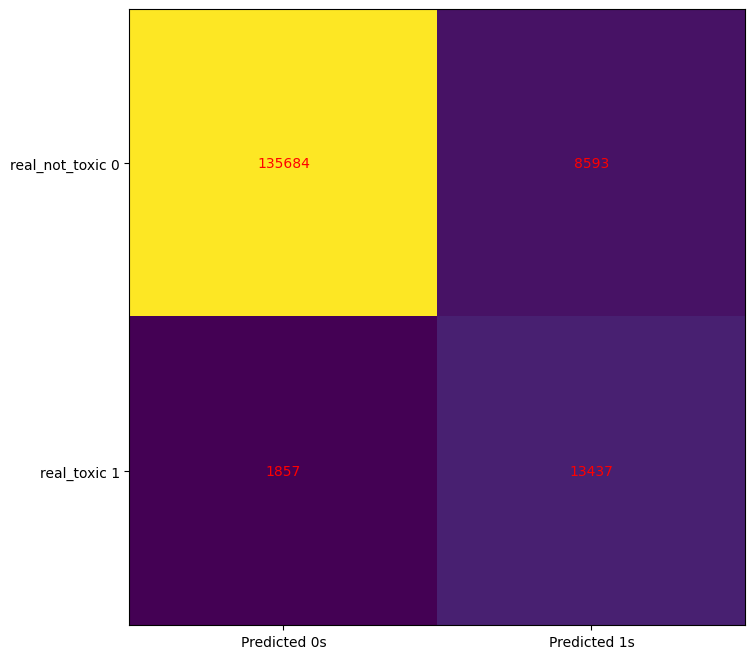

In [61]:
# Calcul de la matrice de confusion : compare les labels réels (y_train) avec les prédictions du modèle
cm = confusion_matrix(y_train, model.predict(X_train))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('real_not_toxic 0', 'real_toxic 1'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## Évaluation sur les données de test

Nous utilisons le modèle pour prédire les étiquettes des données de test et évaluons sa performance avec :
1. Un **rapport de classification** (précision, rappel, F1-score).
2. Une **matrice de confusion** pour visualiser les résultats.

Cela nous donne des insights sur la capacité du modèle à généraliser sur les autre labels .


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92     57888
           1       0.41      0.90      0.57      6090

    accuracy                           0.87     63978
   macro avg       0.70      0.88      0.75     63978
weighted avg       0.93      0.87      0.89     63978



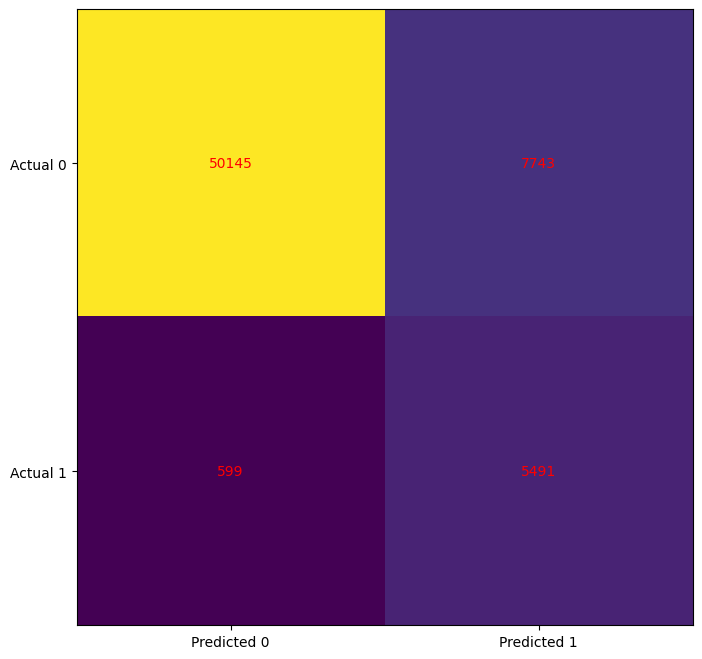

In [62]:
# Effectuer des prédictions sur les données de test
# Transformer les données de test avec le même vectoriseur (sans fit)
X_test_tfidf_t = pipeline.transform(data_test["comment_clean"])  
y_test = data_test["toxic"]  # Remplace par les vraies étiquettes de test

# Faire les prédictions
y_pred = model.predict(X_test_tfidf_t)

# Afficher le rapport de classification
print("Classification Report:\n", classification_report(y_test, y_pred))

# Afficher la matrice de confusion
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## Classification multi-étiquettes avec Logistic Regression

Pour traiter plusieurs étiquettes (`toxic`, `severe_toxic`, etc.), nous utilisons un classifieur multi-sortie (`MultiOutputClassifier`).  
Chaque étiquette est prédite individuellement avec un modèle de régression logistique.
Voici les choix des paramètres pour ce modèle :

1. **`solver='liblinear'`** :  
   Ce solveur est bien adapté aux problèmes de classification binaire. Chaque étiquette étant une classification binaire dans notre cas, ce solveur est optimal.

2. **`C=1.0`** :  
   Ce paramètre contrôle la régularisation. Une valeur par défaut de `1.0` équilibre la régularisation et l’ajustement du modèle. Cela permet de prévenir le surapprentissage sans sous-apprentissage.

3. **`class_weight='balanced'`** :  
   Les classes dans les données sont déséquilibrées (ex. peu de commentaires `toxic` par rapport aux `non-toxic`). Ce paramètre ajuste automatiquement les poids des classes en fonction de leur fréquence dans les données d'entraînement, ce qui améliore les performances pour les classes rares.

4. **`random_state=0`** :  
   Permet de fixer une graine pour la reproductibilité des résultats.
   
Les résultats pour chaque étiquette sont évalués à l'aide des métriques suivantes :
- Précision
- Rappel
- F1-score
- Exactitude (accuracy)


In [63]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Liste des étiquettes
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Données cibles multi-étiquettes (binaire pour chaque étiquette)
y_train_m = data_train[labels]
X_train_m = X_tfidf
# Modèle multi-étiquette
multi_target_model = MultiOutputClassifier(LogisticRegression(solver='liblinear', C=1.0,class_weight='balanced', random_state=0))

# Entraîner le modèle
multi_target_model.fit(X_train_m, y_train_m)

# Prédictions
X_test_tfidf_t = pipeline.transform(data_test["comment_clean"])
y_pred_multi = multi_target_model.predict(X_test_tfidf_t)

# Initialiser un DataFrame pour stocker les résultats
results = []

# Évaluer chaque étiquette
for i, label in enumerate(labels):
    print(f"Évaluation de l'étiquette: {label}")
    
    # Obtenir les vraies étiquettes et les prédictions pour chaque étiquette
    y_test_label = data_test[label]
    y_pred_label = y_pred_multi[:, i]
    
    # Calculer le rapport de classification
    report = classification_report(
        y_test_label, 
        y_pred_label, 
        zero_division=0,  # Évite les avertissements
        output_dict=True
    )
    
    # Calculer l'accuracy pour chaque étiquette
    accuracy = accuracy_score(y_test_label, y_pred_label)
    
    # Ajouter les résultats au tableau
    results.append({
        "Label": label,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-Score": report['weighted avg']['f1-score'],
        "Accuracy": accuracy  # Ajouter l'accuracy à chaque étiquette
    })

# Afficher les résultats sous forme de tableau
results_df = pd.DataFrame(results)
print(results_df)
print(accuracy_score(y_test_label,y_pred_label))


Évaluation de l'étiquette: toxic
Évaluation de l'étiquette: severe_toxic
Évaluation de l'étiquette: obscene
Évaluation de l'étiquette: threat
Évaluation de l'étiquette: insult
Évaluation de l'étiquette: identity_hate
           Label  Precision    Recall  F1-Score  Accuracy
0          toxic   0.933954  0.864250  0.885611  0.864250
1   severe_toxic   0.994415  0.956329  0.973066  0.956329
2        obscene   0.959423  0.922911  0.935285  0.922911
3         threat   0.996610  0.984010  0.989484  0.984010
4         insult   0.958352  0.902404  0.921804  0.902404
5  identity_hate   0.989235  0.952234  0.967636  0.952234
0.9522335802932258


## Résultats finaux

Le modèle multi-étiquette a permis de prédire les différentes catégories de toxicité.  
Les performances (précision, rappel, F1-score) varient selon les étiquettes, mais montrent que la régression logistique est efficace pour ce problème.  
Des modèles plus avancés pourraient améliorer ces résultats, notamment pour les classes déséquilibrées.


## Les classes predites 


In [64]:
# Maintenant, pour chaque commentaire, on imprime l'étiquette qui a la plus haute probabilité .
for i, pred in enumerate(y_pred_multi):
    # Trouver l'indice de la classe avec la plus haute probabilité
    pred_class = labels[pred.argmax()]
    print(f"Commentaire {i+1} : {pred_class}")

Commentaire 1 : toxic
Commentaire 2 : toxic
Commentaire 3 : toxic
Commentaire 4 : toxic
Commentaire 5 : toxic
Commentaire 6 : toxic
Commentaire 7 : toxic
Commentaire 8 : toxic
Commentaire 9 : toxic
Commentaire 10 : toxic
Commentaire 11 : toxic
Commentaire 12 : toxic
Commentaire 13 : toxic
Commentaire 14 : toxic
Commentaire 15 : toxic
Commentaire 16 : toxic
Commentaire 17 : toxic
Commentaire 18 : toxic
Commentaire 19 : toxic
Commentaire 20 : toxic
Commentaire 21 : toxic
Commentaire 22 : toxic
Commentaire 23 : toxic
Commentaire 24 : toxic
Commentaire 25 : toxic
Commentaire 26 : toxic
Commentaire 27 : toxic
Commentaire 28 : toxic
Commentaire 29 : toxic
Commentaire 30 : toxic
Commentaire 31 : obscene
Commentaire 32 : toxic
Commentaire 33 : identity_hate
Commentaire 34 : toxic
Commentaire 35 : toxic
Commentaire 36 : toxic
Commentaire 37 : toxic
Commentaire 38 : toxic
Commentaire 39 : toxic
Commentaire 40 : toxic
Commentaire 41 : toxic
Commentaire 42 : toxic
Commentaire 43 : toxic
Commentair

## Other models

**Choose a model between the following:**
* **K-Nearest Neighbors (*KNN*)**
* **Decision Tree**
* **Random Forest**

**Describe IN YOUR OWN WORDS (plagiarism checks will be made if needed) how the method works, and implement it for the current case, discussing its hyperparameters as well.**

In [65]:
## Write your code here

## Compare models

One must then compare the models on the test set and provide metrics to study it.

**Compare previously studied models, with counting *tf* and *tf-idf* as vectorizers, for their best hyperparameters.**

In [66]:
## Write your code here

## Use your model

**Use the best model to build a Command-Line Interface (*CLI*) that is launched by the command `./cli.py [options]` using the `argsparse` module, and that accepts in stdin (standard input) english sentences and classifies them, displaying the result and interesting metrics if relevant.**